# 数据透视表

我们已经介绍过 `GroupBy` 抽象类是如何探索数据集内部的关联性的了。  
**数据透视表**（`pivot table`）是一种类似的操作方法，常见于 `Excel` 与类似的表格应用中。  
数据透视表将每一列数据作为输入，输出将数据不断细分成多个维度累计信息的二维数据表。  
人们有时容易弄混数据透视表与 `GroupBy`，但我觉得数据透视表更像是一种**多维的 `GroupBy`** 累计操作。  
也就是说，虽然你也可以分割 - 应用 - 组合，但是分割与组合不是发生在一维索引上，而是在二维网格上（行列同时分组）。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## 1. 演示数据透视表

这一节的示例将采用泰坦尼克号的乘客信息数据库来演示，可以在 `Seaborn` 程序库（详情请参见 4.16 节）获取：  
这份数据包含了惨遭厄运的每位乘客的大量信息，包括性别（gender）、年龄（age）、船舱等级（class）和船票价格（fare paid）等。

In [2]:
titanic = sns.load_dataset('titanic')  # 自动从seaborn网站下载数据，可能会很慢

In [3]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# titanic.to_csv('../data/seaborn_titanic.csv')  # 本地备份一份数据，20210915

## 2. 手工制作数据透视表

In [5]:
titanic.groupby('sex')[['survived']].mean()  # 用 GroupBy 来实现统计不同性别乘客的生还率

,survived
sex,
female,0.742038
male,0.188908


In [6]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean')            # 用 groupby 来实现同时观察不同性别与船舱等级的生还情况

sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

In [7]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()  # 用 groupby 来实现同时观察不同性别与船舱等级的生还情况

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


## 3. 数据透视表语法

由于二维的 `GroupBy` 应用场景非常普遍，因此 `Pandas` 提供了一个快捷方式 `pivot_table` 来快速解决多维的累计分析任务。

In [8]:
titanic.pivot_table('survived', index='sex', columns='class')  # 用 DataFrame 的 pivot_table 实现的效果等同于上一节的管道命令的代码

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


### 3.1. 多级数据透视表

与 `GroupBy` 类似，数据透视表中的分组也可以通过各种参数指定多个等级。

In [9]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')  # 把年龄（'age'）也加进去作为第三个维度，这就可以通过 pd.cut 函数将年龄进行分段

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [10]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])  # 用 pd.qcut 将船票价格按照计数项等分为两份，加入数据透视表，结果是一个带层级索引的四维累计数据表，通过网格显示不同数值之间的相关性。

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

### 3.2. 其他数据透视表选项

`DataFrame` 的 `pivot_table` 方法的完整签名如下所示：  
```python
# Pandas 0.18版的函数签名
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```
我们已经介绍过前面三个参数了，现在来看看其他参数。  
`fill_value` 和 `dropna` 这两个参数用于处理缺失值，用法很简单，我们将在后面的示例中演示其用法。  
`aggfunc` 参数用于设置累计函数类型，默认值是均值（`mean`）。  
与 `GroupBy` 的用法一样，累计函数可以用一些常见的字符串（'`sum`'、'`mean`'、'`count`'、'`min`'、'`max`' 等）表示，  
也可以用标准的累计函数（`np.sum()`、`min()`、`sum()` 等）表示。

In [11]:
titanic.pivot_table(index='sex', columns='class', aggfunc={'survived':sum, 'fare':'mean'})  # 还可以通过字典为不同的列指定不同的累计函数

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

In [12]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)  # 当需要计算每一组的总数时，可以通过 margins 参数来设置

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


## 4. 案例：美国人的生日

再来看一个有趣的例子——由美国疾病防治中心（Centers for Disease Control，CDC）提供的公开生日数据。  
这份数据比较简单，只包含了不同出生日期（年月日）与性别的出生人数。

In [13]:
births = pd.read_csv('../data/births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [14]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')  # 各年代的男女出生比例

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


Text(0, 0.5, 'total births per year')

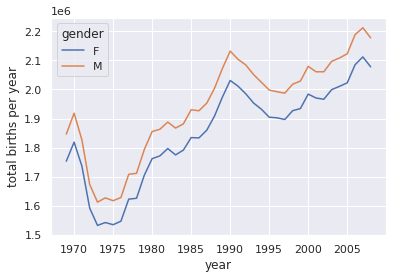

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # 使用seaborn风格

births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year')

### 4.1. 深入探索

#### 4.1.1. 不同年代不同星期的日均出生数据

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'mean births by day')

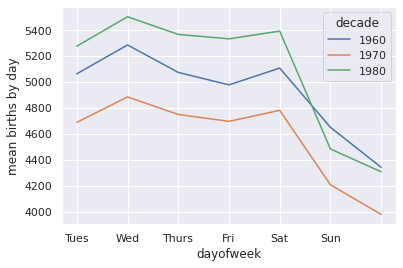

In [16]:
# 我们必须对数据做一点儿清理工作，消除由于输错了日期而造成的异常点（如 6 月 31 号）或者是缺失值（如 1999 年 6月）。
# 消除这些异常的简便方法就是直接删除异常值，可以通过更稳定的 sigma 消除法（sigma-clipping，按照正态分布标准差划定范围，SciPy 中默认是四个标准差）操作来实现
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])
# 最后一行是样本均值的稳定性估计（robust estimate），其中 0.74 是指标准正态分布的分位数间距。
# 在 query() 方法（详情请参见 3.13 节）中用这个范围就可以将有效的生日数据筛选出来了：
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

births['day'] = births['day'].astype(int)                                                              # 将'day'列设置为整数。由于其中含有缺失值null，因此是字符串
births.index = pd.to_datetime(10000 * births.year + 100 * births.month + births.day, format='%Y%m%d')  # 从年月日创建一个日期索引
births['dayofweek'] = births.index.dayofweek

import matplotlib.pyplot as plt
# import matplotlib as mpl

births.pivot_table('births', index='dayofweek', columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day')

#### 4.1.2. 平均每天的出生人数

In [17]:
births_by_date = births.pivot_table('births', [births.index.month, births.index.day])  # 按照月和日两个维度分别对数据进行分组
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

In [18]:
births_by_date.index = [pd.datetime(2012, month, day) for (month, day) in births_by_date.index]  # 虚构一个年份，与月和日组合成新索引（注意日期为 2 月 29 日时，索引年份需要用闰年，例如 2012）
births_by_date.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


<AxesSubplot:>

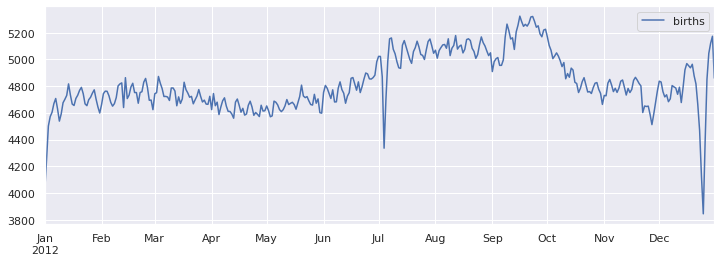

In [19]:
# 将结果画成图
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)